In [16]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
from skimage.morphology import closing, square
from PIL import Image
import matplotlib.pyplot as plt


In [17]:
path = '/Users/linusfalk/Dev/Advanced_image_analysis/data/parkinson5.tiff'

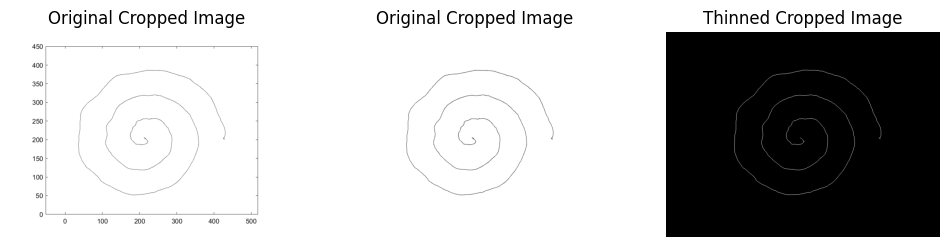

In [18]:
def thin_spiral_image_with_custom_cut(image_path):
    # Load the image and convert it to grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

   
    # White out the specified regions
    cut_img = img.copy()
    cut_img[:57, :] = 255  # Top region
    cut_img[-81:, :] = 255  # Bottom region
    cut_img[:, :122] = 255  # Left region
    cut_img[:, -91:] = 255  # Right region


    # Set all non-white pixels to black
    binary_strict = np.where(cut_img < 255, 0, 255).astype(np.uint8)

    # Invert the binary image for skeletonization
    binary_inverted_strict = cv2.bitwise_not(binary_strict)

    binary_inverted_strict = binary_inverted_strict

    # Skeletonize the image
    skeleton = skeletonize(binary_inverted_strict // 255) * 255

    skeleton_uint8 = skeleton.astype(np.uint8)

    # Closing gaps in skeleton
    #skeleton_uint8 = closing(skeleton_uint8, square(3))


    # Return the cut and skeletonized image for plotting
    return img, cut_img, skeleton_uint8 #skeleton_uint8

# Cut away 122 pixels and process the image
img, cut_img_cropped, skeleton_img_cropped = thin_spiral_image_with_custom_cut(path)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Original image
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Cropped Image')
axes[0].axis('off')

# Original image after cutting 122 pixels from the borders
axes[1].imshow(cut_img_cropped, cmap='gray')
axes[1].set_title('Original Cropped Image')
axes[1].axis('off')

# Thinned image
axes[2].imshow(skeleton_img_cropped, cmap='gray')
axes[2].set_title('Thinned Cropped Image')
axes[2].axis('off')

plt.show()


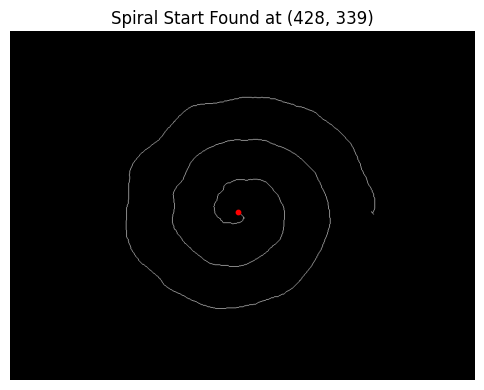

(428, 339)

In [19]:

def find_spiral_start_refined(skeleton_image, point = (0, 0), first = True):
    # Find the center of the image
    if first:
        center_x, center_y = skeleton_image.shape[1] // 2, skeleton_image.shape[0] // 2
    else:
        center_x, center_y = point[0], point[1]
    
    # Define a larger search radius
    search_radius = 200

    # Search for the start of the spiral within the search radius
    for radius in range(1, search_radius + 1):
        for angle in np.linspace(0, 2 * np.pi, 8 * radius):
            x = int(center_x + radius * np.cos(angle))
            y = int(center_y + radius * np.sin(angle))

            if 0 <= x < skeleton_image.shape[1] and 0 <= y < skeleton_image.shape[0]:
                if skeleton_image[y, x] == 255:  # White pixel found
                    return x, y  # Returning the first white pixel found in spiral pattern

    return None  # Return None if no start found

# Find the start of the spiral with the refined method
spiral_start_refined = find_spiral_start_refined(skeleton_img_cropped)

# Plotting the result with the refined start point marked
plt.figure(figsize=(6, 6))
plt.imshow(skeleton_img_cropped, cmap='gray')
if spiral_start_refined:
    plt.scatter(*spiral_start_refined, color='red', s=10)  # Mark the start with a red dot
    plt.title(f'Spiral Start Found at {spiral_start_refined}')
else:
    plt.title('Spiral Start Not Found')
plt.axis('off')
plt.show()

spiral_start_refined


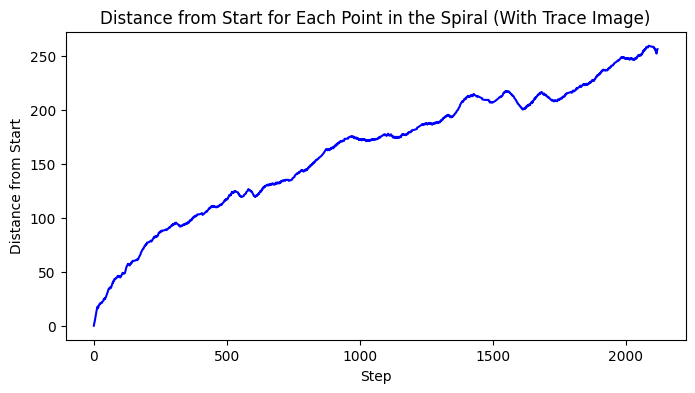

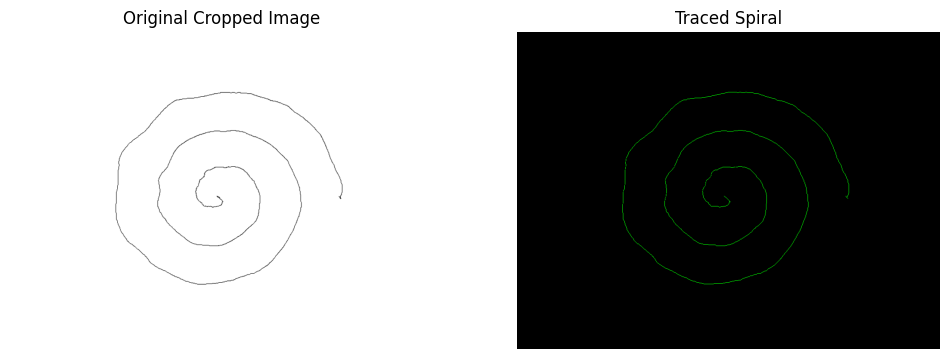

In [27]:

def trace_spiral_and_create_image(skeleton_image, start_point):
    # Create a blank RGB image for visualization
    trace_image = np.zeros((skeleton_image.shape[0], skeleton_image.shape[1], 3), dtype=np.uint8)

    current_point = start_point
    path = [current_point]
    distances = [0.0]

    # Set the starting point in the trace image
    trace_image[current_point[1], current_point[0]] = [255, 0, 0]  # Red for starting point

    while True:
        # Remove the current point from the skeleton image
        skeleton_image[current_point[1], current_point[0]] = 0

        # Mark the current point in the trace image with a different color
        trace_image[current_point[1], current_point[0]] = [0, 255, 0]  # Green for traced path

        # Find the nearest neighbor in the local region
        next_point = find_spiral_start_refined(skeleton_image, (current_point[0], current_point[1]), False) #find_local_nearest_neighbor(skeleton_image, current_point)
        if next_point is None:
            break  # No more neighbors

        # Calculate the distance from the start
        distance = np.sqrt((next_point[0] - start_point[0])**2 + (next_point[1] - start_point[1])**2)
        distances.append(distance)

        # Update the current point
        current_point = next_point
        path.append(current_point)

    return path, distances, trace_image

# Trace the spiral and create the image
skeleton_img_trace = skeleton_img_cropped.copy()
trace_path, trace_distances, trace_result_image = trace_spiral_and_create_image(skeleton_img_trace, spiral_start_refined)

# Convert the trace image to PIL image for saving and displaying
trace_result_pil_image = Image.fromarray(trace_result_image)
trace_image_output_path = '/Users/linusfalk/Dev/Advanced_image_analysis/data/control1_traced.tiff'
trace_result_pil_image.save(trace_image_output_path)


x = np.linspace(0,2000,2000)


# Plot the distances
plt.figure(figsize=(8, 4))
plt.plot(trace_distances, color='blue')
plt.title('Distance from Start for Each Point in the Spiral (With Trace Image)')
plt.xlabel('Step')
plt.ylabel('Distance from Start')
plt.show()

trace_image_output_path



# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image after cutting 122 pixels from the borders
axes[0].imshow(cut_img_cropped, cmap='gray')
axes[0].set_title('Original Cropped Image')
axes[0].axis('off')

# Thinned image
axes[1].imshow(trace_result_pil_image)
axes[1].set_title('Traced Spiral')
axes[1].axis('off')

plt.show()
